# Seattle Airbnb Open Data

**Questions**:


* Where are the most popular neighborhoods in Seattle in terms of Airbnb listings?

* How the pricing fluctuates across the year?

    https://www.vrmintel.com/inside-airbnbs-algorithm/

    https://www.kaggle.com/code/aleksandradeis/airbnb-seattle-reservation-prices-analysis/notebook

* General Exploration on factors that contribute to high review scores

* Cluster analysis of listings in Seattle

    https://rpubs.com/VVictor/388056

    https://www.linkedin.com/pulse/segmenting-clustering-airbnb-listings-zurich-georgios-chatzis

* Predicting review scores using comments aggregated under a listing_id

    http://cs229.stanford.edu/proj2011/MehtaPhilipScaria-Predicting%20Star%20Ratings%20from%20Movie%20Review%20Comments.pdf

* Geospatial visualizations

In [53]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from ipyleaflet import Map, basemaps, Marker, MarkerCluster, Popup
from ipywidgets import HTML
import requests

In [ ]:
API_KEY= '5d0d252623ca4995023618fb3e6aa81e'
API_URL = 'http://api.positionstack.com/v1/forward'

In [18]:
calendar = pd.read_csv('data/calendar.csv')
listings = pd.read_csv('data/listings.csv')
reviews = pd.read_csv('data/reviews.csv')

## Q1: Where are the most popular neighborhoods in Seattle in terms of Airbnb listings?

The first question I would like to explore on is to generate an aggregated view of all airbnb listings. Here in a perspective in the level of neighborhoods. Interested in the most popular ones, I first though need to define what does "popularity" entail here. I would like to clarify it in two metrics: (which there is high chance that these two metrics are related anyway)
* the sheer amount of listings, and 
* the revenue that could be potentially generated from these listings

The dataset we will use for this analysis is `listings.csv`. By figuring out the question, we would also like to take a deeper look at the dataset.

### Initial Data Preparation

#### The First Look at the Data

#### Missing Values

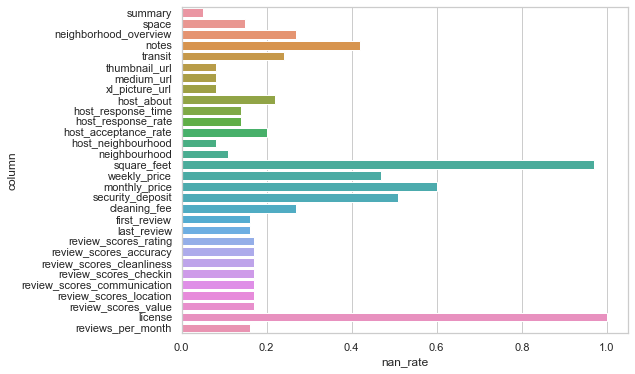

In [20]:
listings_nans_rate = listings.isnull().mean().round(2).reset_index().set_axis(["column", "nan_rate"], axis=1)
listings_nans = listings_nans_rate[listings_nans_rate['nan_rate'] > 0]

sns.set(rc={"figure.figsize":(8, 6)})
sns.set_theme(style="whitegrid", palette="pastel")
sns.barplot(x="nan_rate", y="column", data=listings_nans);

We could tell from the diagram that the columns we are missing the most data is the `license` of the listings and the size in terms of areas of the listings(`square_feet`). We are going to drop the columns. 

There are some other groups of columns that we may consider dropping. For example `thumbnail_url`, `medium_url`, and `xl_picture_url` are all irrelevant to the analysis, thus fine for dropping. Similarly, the group of columns about reviews could be dropped for now as we are not using it for analysis. 

Missing values in some columns, on the other hand, are implying particular situations. For example, columns about listing prices have high percentage of missing values (`weekly_price`: 0.47, `monthly_price`: 0.60, `security_deposit`: 0.51, `cleaning_fee`: 0.27). This does not necessarily implies missing values but rather shows the kind of services a listing provide, e.g. whether to offer monthly rental. Similarly, columns about reviews have a consistent amount of missing values (`review_scores_x`: 0.17). This is because if `number_of_reviews` is 0 then all review score values will be missing. Therefore it might be worthy considering imputing values for these columns. 

In [22]:
listings.drop(columns=['license', 'square_feet',       # missing most data
                       'listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', # irrelevant/uninformational
                       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',    
                       'host_url', 'host_name',                                            
                       'city', 'state', 'market', 'smart_location', 'country_code', 'country', 
                       'has_availability', 'calendar_last_scraped', 'jurisdiction_names'], inplace=True)

#### Data Types Conversion

#### Categorical Data

In total 84849 reviews for 3191 listings from 75730 reviewers. There are 3818 listings. 

### Analyze, Model, and Visualize

In [31]:
listings[listings.neighbourhood!=listings.neighbourhood_cleansed][['neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed']].sample(3)

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
200,Lower Queen Anne,East Queen Anne,Queen Anne
2737,Capitol Hill,Broadway,Capitol Hill
1457,NaN,International District,Downtown


Now we would like to aggregate listings according to their neighbourhoods. In the dataset, there are however 3 variables that contain relevant data: `neighbourhood`, `neighbourhood_cleansed`, `neighbourhood_group_cleansed`. 

From data sampling on records with different values on the three columns we could see that `neighbourhood` column will be least appropriate one for analysis due to missing values, which are fixed in other 2 columns. `neighbourhood_cleansed` provides location information that is more detailed and street-blocked compared to `neighbourhood_group_cleansed`. For first round of analysis, we may use the `neighbourhood_group_cleansed` for the analysis.

In [33]:
print('There are in total {} active Airbnb listings in Seattle across {} neighborhoods.'.format(
                            listings.shape[0],listings['neighbourhood_group_cleansed'].value_counts().shape[0])
     )

There are in total 3818 active Airbnb listings in Seattle across 17 neighborhoods.


In [260]:
listings_by_neighbourhood = listings.neighbourhood_group_cleansed.value_counts().to_dict()
listings_by_neighbourhood.pop('Other neighborhoods', None)
listings.neighbourhood_group_cleansed.value_counts().reset_index().set_axis(["neighbourhood", "n_listings"], axis=1).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
neighbourhood,Other neighborhoods,Capitol Hill,Downtown,Central Area,Queen Anne,Ballard,West Seattle,Rainier Valley,University District,Beacon Hill,Cascade,Northgate,Delridge,Lake City,Magnolia,Seward Park,Interbay
n_listings,794,567,530,369,295,230,203,159,122,118,89,80,79,67,61,44,11


We could find that 794 listings are grouped as other neighbourhoods. We are going to drop these data since they could not be visualized. Now we attempt to plot these listings in the group of neighbourhood onto the map. 

In [265]:
#TODO: need refactor and functionalized. 

coord_data = dict()

for neighbourhood in listings_by_neighbourhood:
    
    url = API_URL + '?access_key=' + API_KEY \
                  + '&query=' + neighbourhood + ', Seattle'
    response = requests.get(url)
    
    try:
        data = response.json()
    except:
        print("Error expecting value")
        
    coord_data[neighbourhood] = data

Error expecting value


In [267]:
center = (47.608013, -122.335167)

m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=11.5)

markers = []
for neighbourhood in coord_data:
    loc = (coord_data[neighbourhood]['data'][0]['latitude'], coord_data[neighbourhood]['data'][0]['longitude'])
    markers.append(Marker(location=loc, draggable=False))
    
    message2 = HTML()
    message2.value = neighbourhood + ": " + str(listings_by_neighbourhood[neighbourhood])
    markers[-1].popup = message2

marker_cluster = MarkerCluster(
    markers=tuple(markers)
)
m.add_layer(marker_cluster);

m

Map(center=[47.608013, -122.335167], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

We could see that the most popular areas are in the central district and downtown area. 

We then would like to see in terms of availability and revenue, which neighbourhood is the most popular. That means we need to include the information of `calendar.csv` dataset in. 

In [38]:
print('The calendar.csv dataset contains {} price records for {} Airbnb listings in Seattle from {} to {}.'.format(
            calendar.shape[0],listings.shape[0], calendar['date'].iloc[0], calendar['date'].iloc[-1]))

The calendar.csv dataset contains 1393570 price records for 3818 Airbnb listings in Seattle from 2016-01-04 to 2017-01-02.


## Q2: Where are the most popular neighborhoods in Seattle in terms of Airbnb listings?

## Deliverables

* A Github repository for your code (technical audience)
    * A README.md file that communicates the libraries used, the motivation for the project, the files in the repository with a small description of each, a summary of the results of the analysis, and necessary acknowledgments.
    * Your code in a Jupyter notebook, with appropriate comments, analysis, and documentation.
    * You may also provide any other necessary documentation you find necessary.

* A blog post of your findings (non-technical audience)

    * A clear and engaging title and image.
    * Your questions of interest.
    * Your findings for those questions with a supporting statistic(s), table, or visual.